# Pre-Trained Word Embeddings for Text Classification

# Imports/Installations

In [1]:
!pip install transformers
!pip install -U datasets

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from collections import defaultdict, Counter
import json
import numpy as np
import torch
import pandas as pd

from matplotlib import pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset, DatasetDict
from torch.utils.data import DataLoader
#from transformers import DistilBertConfig, DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertModel
from transformers import get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
from torch.optim import AdamW
from transformers import set_seed
from sklearn.metrics import accuracy_score, f1_score
from datasets import load_dataset, DatasetDict, Dataset
from torch.utils.data import DataLoader

from transformers import ElectraTokenizer, ElectraForSequenceClassification

# Loading and formatting CSVs

In [ ]:
#df = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/Labeled Data/BERTopic_results.csv')
#test = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/Labeled Data/BERTopic_TEST.csv')
#train = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/Labeled Data/BERTopic_TRAIN.csv')
#validation = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/Labeled Data/BERTopic_VAL.csv')

# turning into hugging face format
#test = Dataset.from_pandas(test)
#train = Dataset.from_pandas(train)
#validation = Dataset.from_pandas(validation)

In [7]:
df = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Topic Models/bertopic data/BERTopic_results.csv')
df.head()

,Document_Num,Dominant_Topic,Topic_%_Contrib,Topic_Keywords,Text,Is_Outlier,Dom_Topics_Num,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_0_Perc,Topic_1_Perc,Topic_2_Perc,Topic_3_Perc,Topic_4_Perc,Topic_5_Perc
0,0,3,0.53,"hershey, peatland, deforestation, development,...",non compliant products amanah saham pahang ber...,False,1,0,0,0,1,0,0,0.05,0.08,0.06,0.53,0.09,0.19
1,1,0,1.00,"workers, labour, rights, union, labor, employm...",complaint matter public interest taken complai...,False,1,1,0,0,0,0,0,1.00,0.00,0.00,0.00,0.00,0.00
2,2,5,0.83,"cargill, grievance, direct, deforestation, sup...",grievance concerns allegations deforestation l...,False,1,0,0,0,0,0,1,0.02,0.02,0.03,0.08,0.01,0.83
3,3,2,0.64,"land, communities, plasma, local, rights, hcv,...",grievance astra agro lestari aal failed obtain...,False,1,0,0,1,0,0,0,0.14,0.07,0.64,0.04,0.02,0.09
4,4,2,0.99,"land, communities, plasma, local, rights, hcv,...",allegations 1 yet paid compensation 1099 ha la...,False,1,0,0,1,0,0,0,0.00,0.00,0.99,0.00,0.00,0.00


In [8]:
from sklearn.model_selection import train_test_split

# Assuming your full dataset is in a DataFrame called df
train, validation = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

# Optional: print the number of rows in each split
print("Training set size:", len(train))
print("Validation set size:", len(validation))

Training set size: 356
Validation set size: 90


In [9]:
#df = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/Labeled Data/BERTopic_results.csv')
# test = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/Labeled Data/BERTopic_TEST.csv')

#full size sample shuffled
#train = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Text Classification Models/Classification Data/Base/BERTopic_TRAIN_80.csv')
#validation = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Text Classification Models/Classification Data/Base/BERTopic_VAL_20.csv')

#undersample
#train = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Text Classification Models/Classification Data/Undersampled/threshold_TRAIN_80.csv')
#validation = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Text Classification Models/Classification Data/Undersampled/threshold_VAL_20.csv')

# turning into hugging face format
# test = Dataset.from_pandas(test)
train = Dataset.from_pandas(train)
validation = Dataset.from_pandas(validation)

In [10]:
word_counts = df['Text'].astype(str).apply(lambda x: len(x.split()))

max_words = word_counts.max()
min_words = word_counts.min()
mean_words = word_counts.mean()

print(f"Max words in summary: {max_words}")
print(f"Min words in summary: {min_words}")
print(f"Mean words in summary: {mean_words}")


Max words in summary: 677
Min words in summary: 3
Mean words in summary: 39.125560538116595


# Dataset Tokenization

## Example Tokenization

In [11]:
#tokenizer
name = "google/electra-base-discriminator"
tokenizer = ElectraTokenizer.from_pretrained(name) #what goes here?

sample_input = "We want to use a pretrained tokenizer."
tokenized_inputs = tokenizer(sample_input,
                             return_tensors="pt",
                             padding=True,
                             truncation=True,
                             max_length=512)
print(tokenized_inputs["input_ids"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

tensor([[  101,  2057,  2215,  2000,  2224,  1037,  3653, 23654,  2098, 19204,
         17629,  1012,   102]])


We will use the function that we use to test the tokenizer on a single input. We will also split our data into batches of 128.

In [ ]:
# NOT SURE WHAT MAX LENGTH TO USE?

## Tokenized Train Dataset

In [12]:
#best so far is 512
tokenizer_length = 512

In [13]:
tokenizer = ElectraTokenizer.from_pretrained("google/electra-base-discriminator")

#loads the pretrained tokenizer
# Apply tokenization using map
tokenized_train = train.map(
    lambda example: tokenizer(example['Text'],
                             padding="max_length",
                             truncation=True,
                             max_length=tokenizer_length)  # not sure what length to use
)

# Remove the original text column (we don't need it after tokenization)
tokenized_train = tokenized_train.remove_columns(['Text'])

# Rename 'Dominant_Topic' to 'labels' (standard for transformers)
tokenized_train = tokenized_train.rename_column("Dominant_Topic", "labels")

# Step 4: Set format as pytorch tensors
tokenized_train.set_format("torch")

# Check the results
print("Tokenized dataset features:", tokenized_train.column_names)
print("Dataset size:", len(tokenized_train))
print("\nSample data shapes:")
#print(f"- input_ids: {tokenized_train[0]['input_ids'].shape}")
print(f"- attention_mask: {tokenized_train[0]['attention_mask'].shape}")
print(f"- labels: {tokenized_train[0]['labels']}")
print(f"- labels type: {type(tokenized_train[0]['labels'])}")

Map:   0%|          | 0/356 [00:00<?, ? examples/s]

Tokenized dataset features: ['Document_Num', 'labels', 'Topic_%_Contrib', 'Topic_Keywords', 'Is_Outlier', 'Dom_Topics_Num', 'Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5', 'Topic_0_Perc', 'Topic_1_Perc', 'Topic_2_Perc', 'Topic_3_Perc', 'Topic_4_Perc', 'Topic_5_Perc', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']
Dataset size: 356

Sample data shapes:
- attention_mask: torch.Size([512])
- labels: 0
- labels type: <class 'torch.Tensor'>


In [14]:
tokenized_train['labels'][5]

tensor(4)

## Tokenized Test Dataset

In [ ]:
# Apply the same process to your test set
#tokenized_test = test.map(
#    lambda example: tokenizer(example['Text'],
#                             padding="max_length",
#                             truncation=True,
#                             max_length=tokenizer_length)
#)

#tokenized_test = tokenized_test.remove_columns(['Text'])
#tokenized_test = tokenized_test.rename_column("Dominant_Topic", "labels")
#tokenized_test.set_format("torch")

#print("Test dataset size:", len(tokenized_test))

In [ ]:
#tokenized_test['labels']

## Tokenized Validation Dataset

In [15]:
# Apply the same process to your test set
tokenized_validation = validation.map(
    lambda example: tokenizer(example['Text'],
                             padding="max_length",
                             truncation=True,
                             max_length=tokenizer_length)
)

tokenized_validation = tokenized_validation.remove_columns(['Text'])
tokenized_validation = tokenized_validation.rename_column("Dominant_Topic", "labels")
tokenized_validation.set_format("torch")

print("Test dataset size:", len(tokenized_validation))

Map:   0%|          | 0/90 [00:00<?, ? examples/s]

Test dataset size: 90


## Check Tokenization on train and test

In [16]:
#lets check our tokenization for a few samples
tokenized_train[0:2]

{'Document_Num': tensor([17, 66]),
 'labels': tensor([0, 3]),
 'Topic_%_Contrib': tensor([0.7400, 0.5600]),
 'Topic_Keywords': ['workers, labour, rights, union, labor, employment, members, forced, working, conditions',
  'hershey, peatland, deforestation, development, suppliers, supplier, grievance, mighty, earth, forest'],
 'Is_Outlier': tensor([False, False]),
 'Dom_Topics_Num': tensor([1, 1]),
 'Topic_0': tensor([1, 0]),
 'Topic_1': tensor([0, 0]),
 'Topic_2': tensor([0, 0]),
 'Topic_3': tensor([0, 1]),
 'Topic_4': tensor([0, 0]),
 'Topic_5': tensor([0, 0]),
 'Topic_0_Perc': tensor([0.7400, 0.0400]),
 'Topic_1_Perc': tensor([0.0300, 0.0700]),
 'Topic_2_Perc': tensor([0.1400, 0.0600]),
 'Topic_3_Perc': tensor([0.0200, 0.5600]),
 'Topic_4_Perc': tensor([0.0100, 0.0700]),
 'Topic_5_Perc': tensor([0.0500, 0.1900]),
 '__index_level_0__': tensor([17, 66]),
 'input_ids': tensor([[  101,  2220,  2251,  ...,     0,     0,     0],
         [  101,  1015, 14768,  ...,     0,     0,     0]]),
 

In [17]:
#lets check our tokenization for a few samples
#tokenized_test[0:2]

In [18]:
tokenized_validation[0:2]

{'Document_Num': tensor([284, 358]),
 'labels': tensor([0, 3]),
 'Topic_%_Contrib': tensor([0.9700, 0.5300]),
 'Topic_Keywords': ['workers, labour, rights, union, labor, employment, members, forced, working, conditions',
  'hershey, peatland, deforestation, development, suppliers, supplier, grievance, mighty, earth, forest'],
 'Is_Outlier': tensor([False, False]),
 'Dom_Topics_Num': tensor([1, 1]),
 'Topic_0': tensor([1, 0]),
 'Topic_1': tensor([0, 0]),
 'Topic_2': tensor([0, 0]),
 'Topic_3': tensor([0, 1]),
 'Topic_4': tensor([0, 0]),
 'Topic_5': tensor([0, 0]),
 'Topic_0_Perc': tensor([0.9700, 0.0300]),
 'Topic_1_Perc': tensor([0.0000, 0.1100]),
 'Topic_2_Perc': tensor([0.0100, 0.0500]),
 'Topic_3_Perc': tensor([0.0000, 0.5300]),
 'Topic_4_Perc': tensor([0.0000, 0.2000]),
 'Topic_5_Perc': tensor([0.0100, 0.0800]),
 '__index_level_0__': tensor([284, 358]),
 'input_ids': tensor([[  101,  9989,  2992,  ...,     0,     0,     0],
         [  101, 14860,  4022,  ...,     0,     0,     0]]

# Using DataLoader to Batchify data
Make sure to send your datasets to the Dataloader in order to segment your dataset into batches. Remember that we need batches to run our iterative optimization procedure which is typically some form of Mini-batch Gradient Descent.

In the interest of time we want to finetune our model on a sample of the training set with 309 records instead of the entire 62K sample size

## batch_size

In [19]:
#so far 7 is best test score 50% BUT 9 is he best for 45%
batch_size = 7

In [20]:
#preparing training and validation data for batching
train_dataset = tokenized_train.shuffle(seed=1111)#.select(range(309))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
eval_dataloader = DataLoader(tokenized_validation, batch_size=batch_size)

# Training and Validation
We have now gone through all the required preprocessing to prep the data for training. Instead of the Trainer module, it will be a good practice to initially write our own training loops so that we are mindful of all the steps that required for training neural networks.

Other than our training and validation data we need to select:

An optimizer to run backpropagation
A scheduler that sets a protocol for parameter updates at the end of a batch
We would also like to set a seed at the start of computation. This ensures that we are able to generate reproducicble results across multiple training sessions.

We run validation at the end of each epoch.

**At the end of this step we want to report the best validation loss obtained during training. We also want to save the model corresponding to the epoch that reported the best validation loss.**

In [21]:
model_path = '/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Text Classification Models/Electra_Saved_Models/Electra '

In [22]:
from torch.nn.utils import clip_grad_norm_
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from transformers import ElectraConfig

#loads model for classification with 6 topic classes
config = ElectraConfig.from_pretrained(name, num_labels=6, hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1)
model = ElectraForSequenceClassification.from_pretrained(name, num_labels=6).to(device)

#had error, so moved this up from after the lr_scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

num_epochs = 20
# num_training_steps = len(train_dataloader)
# INSTEAD OF ABOVE USE THIS
num_training_steps = len(train_dataloader) * num_epochs
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),  # 10% warmup
    num_training_steps=num_training_steps
)

#lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# For Graph
x_epochs = []
y_train = []
y_val = []

best_val_loss = float("inf")

early_stopping = True
early_count = 0 # +1 every time validation loss doesnt improve

progress_bar = tqdm(range(num_training_steps))

#training loop, standard
#forward pass, loss, back propagation, gradient clipping, optimizer step, scheduler step
for epoch in range(num_epochs):
    x_epochs.append(epoch)

    # training
    model.train()
    training_losses = []
    for batch_i, batch in enumerate(train_dataloader):

        optimizer.zero_grad()

        # copy input to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # output = model(**batch)
        output = model(input_ids, attention_mask=attention_mask, labels=labels)
        training_loss = output.loss
        training_losses.append(training_loss.item())

        #backprop and update params by taking an optimization step
        # IMPROVING THE MODEL
        output.loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)  # ADD THIS LINE
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update(1)
    print(f"Epoch {epoch}")
    print("Mean Training Loss", np.mean(training_losses))
    y_train.append(np.mean(training_losses))

    # validation
    val_loss = 0
    #evaluation
    model.eval() #important to call because we dont want to collect gradients
    for batch_i, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            # copy input to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            # output = model(**batch)
            output = model(input_ids, attention_mask=attention_mask, labels=labels)
        val_loss += output.loss

    avg_val_loss = val_loss / len(eval_dataloader)
    print(f"Validation loss: {avg_val_loss}")
    y_val.append(avg_val_loss.cpu())

    if avg_val_loss < best_val_loss:
        print("Saving checkpoint!")
        early_count = 0 # Reset counter
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            # 'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_val_loss,
            },
            f"{model_path}best_model_predict.pt"
        )
    elif early_stopping:
        early_count += 1

        if early_count == 10:
            print(f"Validation loss has not improved for {early_count} iterations; Early Stopping.")
            break

    print()

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1020 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `ElectraSelfAttention.forward`.
  return forward_call(*args, **kwargs)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 0
Mean Training Loss 1.7831393667295867
Validation loss: 1.722087025642395
Saving checkpoint!

Epoch 1
Mean Training Loss 1.606386563357185
Validation loss: 1.3361974954605103
Saving checkpoint!

Epoch 2
Mean Training Loss 1.1960652891327352
Validation loss: 0.9701613783836365
Saving checkpoint!

Epoch 3
Mean Training Loss 0.766888700279535
Validation loss: 0.8682411313056946
Saving checkpoint!

Epoch 4
Mean Training Loss 0.6396425126814375
Validation loss: 0.6904733180999756
Saving checkpoint!

Epoch 5
Mean Training Loss 0.33587612971371295
Validation loss: 0.6746771335601807
Saving checkpoint!

Epoch 6
Mean Training Loss 0.33296318874493536
Validation loss: 0.9539333581924438

Epoch 7
Mean Training Loss 0.16634736266717606
Validation loss: 0.9150391221046448

Epoch 8
Mean Training Loss 0.14155114376369646
Validation loss: 0.761830747127533

Epoch 9
Mean Training Loss 0.08254036258942649
Validation loss: 0.6855483055114746

Epoch 10
Mean Training Loss 0.06369773280240741
Validat

Text(0.5, 0, 'Epochs')

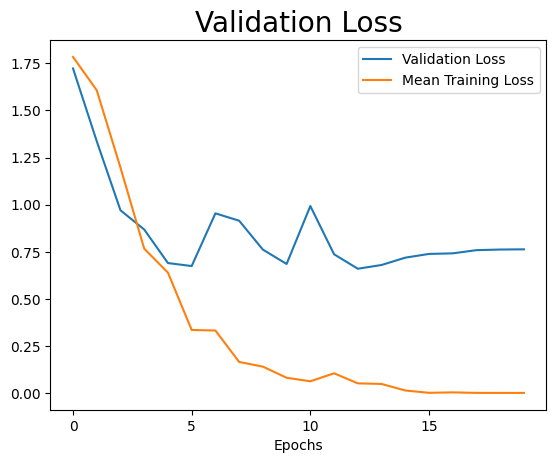

In [23]:
# plt.plot(x_epochs, y_val)

plt.plot(x_epochs, y_val, label="Validation Loss")
plt.plot(x_epochs, y_train, label="Mean Training Loss")
plt.legend()
plt.style.use('fivethirtyeight')
plt.title("Validation Loss")
plt.xlabel("Epochs")


#### **Evaluate your model on Test Data**

Now we use our finetuned model to evaluate the test set. We use performance metrics from `sklearn.metrics` to test the effectiveness of our model on unseen test data.

In order to do that, run the finetuned model you have just saved on your test data and report the following performance metrics:



*   Accuracy
*   F1 Score

In [24]:
# Modify the location per model
model_location = f"{model_path}best_model_predict.pt"
checkpoint = torch.load(model_location)
# Recreate the model architecture
model = ElectraForSequenceClassification.from_pretrained(name, num_labels=6)

# Load the saved weights
model.load_state_dict(checkpoint["model_state_dict"], strict=False)
model.to(device)
model.eval()

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

#### **Evaluate your model on Test Data**

Now we use our finetuned model to evaluate the test set. We use performance metrics from `sklearn.metrics` to test the effectiveness of our model on unseen test data.

In order to do that, run the finetuned model you have just saved on your test data and report the following performance metrics:



*   Accuracy
*   F1 Score

In [25]:
eval_dataloader = DataLoader(tokenized_validation, batch_size=len(tokenized_validation))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()
test_batch_logits = []
y_true = []
for batch_i, batch in enumerate(eval_dataloader):
    with torch.no_grad():
        # copy input to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].cpu().detach().numpy()
        # output = model(**batch)
        output = model(input_ids, attention_mask=attention_mask)
        test_batch_logits.append(output.logits)
        y_true.extend(labels)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `ElectraSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [26]:
print(len(test_batch_logits),len(eval_dataloader))
test_logits = torch.cat(test_batch_logits, dim=0)

#sanity check -> dimension 0 of your logits tensor should be same as the size of the test dataset
print(test_logits.shape,len(tokenized_validation),len(y_true))

1 1
torch.Size([90, 6]) 90 90


In [27]:
#Convert the logits to predicted labels
y_pred = torch.argmax(test_logits, dim = 1).cpu().numpy()
print(y_true[:10])
print(y_pred[:10])

#sanity check: should have as many predictions as labels
assert len(y_pred)==len(y_true)

[np.int64(0), np.int64(3), np.int64(3), np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(2), np.int64(5), np.int64(4)]
[0 3 3 1 2 4 5 2 0 3]


## F1 & Accuracy Scores

In [28]:
print('F1 Score (macro):', f1_score(y_true, y_pred, average='macro'))
print('F1 Score (weighted):', f1_score(y_true, y_pred, average='weighted'))
print('F1 Score (micro):', f1_score(y_true, y_pred, average='micro'))
print('Accuracy Score:', accuracy_score(y_true, y_pred))

F1 Score (macro): 0.8741128094003838
F1 Score (weighted): 0.889603848433921
F1 Score (micro): 0.8888888888888888
Accuracy Score: 0.8888888888888888


In [29]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=['0','1','2','3','4','5']))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       0.67      0.67      0.67         9
           2       0.93      0.88      0.90        16
           3       0.80      0.94      0.86        17
           4       0.93      0.88      0.90        16
           5       1.00      0.89      0.94        18

    accuracy                           0.89        90
   macro avg       0.88      0.87      0.87        90
weighted avg       0.89      0.89      0.89        90



# Predicting

In [46]:
model_name = "Electra"

In [47]:
# Load new data for classification
new_data_path = '/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Topic Models/combined_testing.csv'
new_df = pd.read_csv(new_data_path)

print(f"Loaded {len(new_df)} entries for classification")
print("Columns in new data:", new_df.columns.tolist())

# Prepare the text data (assuming 'summary' column contains the text to classify)
# If your text column has a different name, change 'summary' below
text_column = 'summary'

# Convert to Dataset format
new_dataset = Dataset.from_pandas(new_df[[text_column]])

# Tokenize the new data
tokenized_new_data = new_dataset.map(
    lambda example: tokenizer(str(example[text_column]),  # Convert to string to handle NaN
                             padding="max_length",
                             truncation=True,
                             max_length=tokenizer_length)
)

# Remove the original text column
tokenized_new_data = tokenized_new_data.remove_columns([text_column])

# Set format to torch tensors
tokenized_new_data.set_format("torch")

# Create DataLoader for inference
inference_dataloader = DataLoader(tokenized_new_data, batch_size=batch_size)

# Run inference
model.eval()   # LOAD BEST MSODEL
all_predictions = []

with torch.no_grad():
    for batch in tqdm(inference_dataloader, desc="Classifying"):
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # Get model predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Convert logits to predicted labels
        predictions = torch.argmax(logits, dim=1).cpu().numpy()
        all_predictions.extend(predictions)


# Add predictions to the new_df DataFrame
new_df[f'{model_name}_label'] = all_predictions

print(f"\nClassification complete!")
print(f"Label distribution:")
# Add Label
print(new_df[f'{model_name}_label'].value_counts().sort_index())

output_path = '/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Text Classification Models/classified_grievances.csv'
new_df.to_csv(output_path, index=False)

print("\nFirst 10 classified entries:")
print(new_df[['summary', f'{model_name}_label']].head(10))

Loaded 120 entries for classification
Columns in new data: ['pk', 'source', 'internal_id', 'status', 'submitted_on', 'accepted_on', 'last_updated_on', 'country', 'region', 'complainants', 'respondents', 'respondent_sector', 'respondent_parent_company', 'respondent_supplier', 'summary', 'history', 'external_link', 'extras']


Map:   0%|          | 0/120 [00:00<?, ? examples/s]

Classifying:   0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `ElectraSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Classification complete!
Label distribution:
Electra_label
0    20
1    26
2    11
3    12
4    19
5    32
Name: count, dtype: int64

First 10 classified entries:
                                             summary  Electra_label
0  In May/June 2021, Eyes On the Forest (EOF) pub...              1
1  It is alleged that the company has cleared HCV...              1
2  The grievance against YPJ Plantations alleges ...              5
3  Greenpeace filed a grievance against Goodhope ...              5
4  A grievance was filed against Brasil Bio Fuels...              5
5  Greenpeace raised a grievance against Bumitama...              5
6  Alleged involvement in labour right issues by ...              0
7                                                NaN              0
8                                                NaN              0
9  Allegations:-(i) Developing a Palm Oil Plantat...              3


In [48]:
label_map = {
    0: 'Failed Compensation/Land Rights',
    1: 'Environmental Impact',
    2: 'Administrative',
    3: 'Deforestation',
    4: 'Labour Rights',
    5: 'Illegal or Contaminated FFB'
}

results_df[f'{model_name}_topic'] = results_df[f'{model_name}_label'].map(label_map)
results_df

,pk,manual_label,Confident,summary,DistilBERT_label,SpanBERT_label,Electra_label,Twitter_label,XLNet_label,BERT_label,Electra_topic
0,431,2,False,"In July 2020, Cargill received a grievance aga...",2,2,5,0,2,3,Illegal or Contaminated FFB
1,432,0,True,A grievance was filed against Agropalma regard...,0,0,5,0,0,0,Illegal or Contaminated FFB
2,433,0,True,This grievance was filed by Friends of the Ear...,0,0,2,0,0,0,Administrative
3,434,4,True,A grievance was filed against Brasil Bio Fuels...,5,4,5,0,0,2,Illegal or Contaminated FFB
4,435,0,True,A grievance was filed by Link-Ar Borneo agains...,0,0,5,0,0,0,Illegal or Contaminated FFB
...,...,...,...,...,...,...,...,...,...,...,...
165,596,3,True,A grievance has been filed against PT ASM rega...,3,3,5,1,3,3,Illegal or Contaminated FFB
166,597,1,True,The grievance concerns PT SIL & SIP (Sebakis I...,1,0,2,2,0,1,Administrative
167,598,2,True,The grievance involves a report by Rainforest ...,2,2,5,2,2,2,Illegal or Contaminated FFB
168,599,5,True,This grievance concerns the deforestation of T...,3,2,3,2,3,1,Deforestation


In [49]:
# --- Evaluation ---
true_labels = results_df['manual_label'].astype(int).values
pred_labels = np.array(all_predictions)

print("Evaluation on New Data:")
print("F1 Score (macro):", f1_score(true_labels, pred_labels, average='macro'))
print("F1 Score (weighted):", f1_score(true_labels, pred_labels, average='weighted'))
print("F1 Score (micro):", f1_score(true_labels, pred_labels, average='micro'))
print("Accuracy:", accuracy_score(true_labels, pred_labels))

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=[
    'Failed Compensation/Land Rights',
    'Environmental Impact',
    'Administrative',
    'Deforestation',
    'Labour Rights',
    'Illegal or Contaminated FFB'
]))

Evaluation on New Data:


ValueError: Found input variables with inconsistent numbers of samples: [170, 120]

Electra_topic
Deforestation                      129
Labour Rights                       19
Failed Compensation/Land Rights     10
Administrative                       8
Environmental Impact                 4
Name: count, dtype: int64


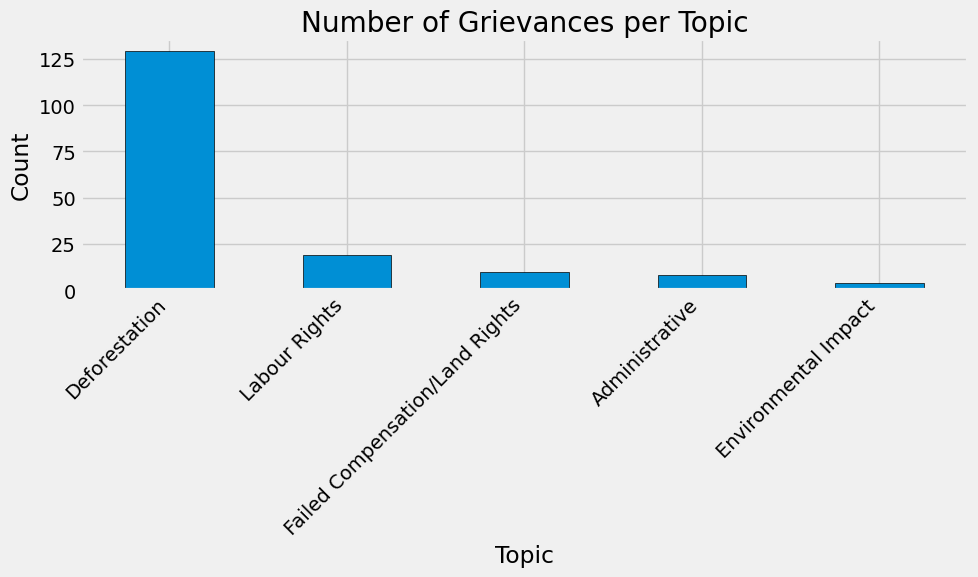

In [ ]:
import matplotlib.pyplot as plt

topic_counts = results_df['Electra_topic'].value_counts()
print(topic_counts)

plt.figure(figsize=(10, 6))
topic_counts.plot(kind='bar', edgecolor='black')
plt.title('Number of Grievances per Topic')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
results_df[results_df[f'{model_name}_label'] == 0]

,pk,manual_label,Confident,summary,DistilBERT_label,SpanBERT_label,Electra_label,Twitter_label,XLNet_label,Electra_topic
2,433,0,True,This grievance was filed by Friends of the Ear...,0,0,0,0,0,Failed Compensation/Land Rights
10,441,0,True,The grievance concerns a community land confli...,0,0,0,0,0,Failed Compensation/Land Rights
21,452,0,True,This grievance involves a community land confl...,0,0,0,0,0,Failed Compensation/Land Rights
29,460,1,True,This grievance involves a land conflict disput...,0,0,0,0,0,Failed Compensation/Land Rights
52,483,0,True,A grievance was raised in July 2019 regarding ...,0,0,0,0,0,Failed Compensation/Land Rights
65,496,0,True,A grievance was filed against PT Andika Permat...,0,0,0,0,0,Failed Compensation/Land Rights
74,505,0,True,This grievance case involves a community land ...,2,0,0,0,0,Failed Compensation/Land Rights
101,532,0,True,The grievance against La Fabril alleges land a...,0,0,0,0,0,Failed Compensation/Land Rights
150,581,0,True,This grievance involves PT Karangjuang Hijau L...,0,0,0,0,0,Failed Compensation/Land Rights
153,584,0,True,The grievance alleges that Astra Agro Lestari ...,2,0,0,0,0,Failed Compensation/Land Rights


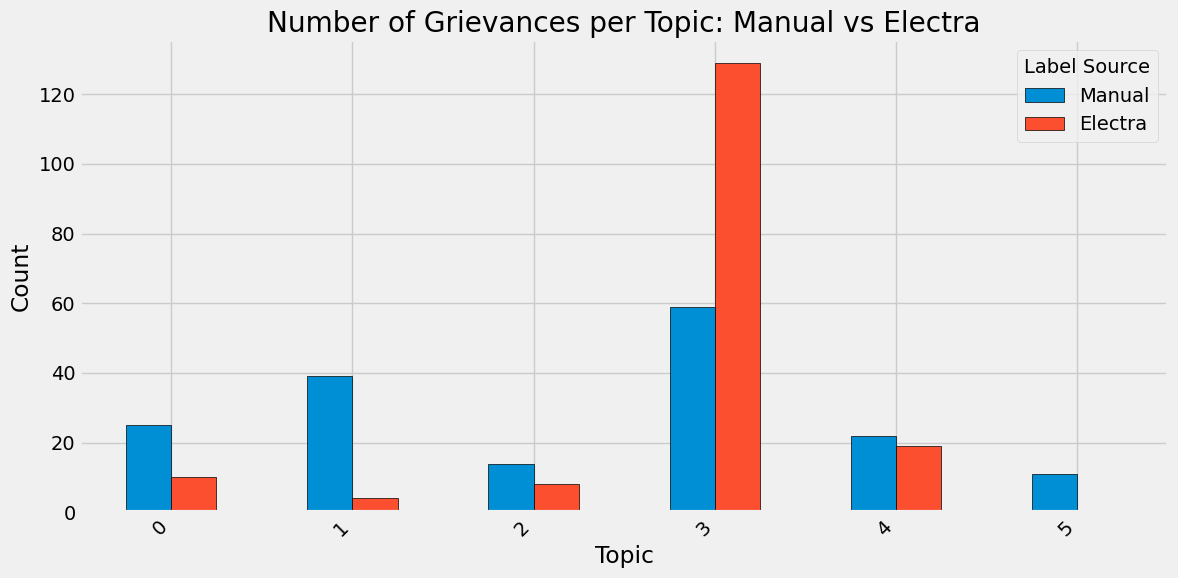

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
# Get counts
manual_counts = results_df['manual_label'].value_counts()
distilbert_counts = results_df['Electra_label'].value_counts()
combined_counts = pd.DataFrame({
    'Manual': manual_counts,
    'Electra': distilbert_counts
}).fillna(0)
combined_counts = combined_counts.sort_index()
# Plot
combined_counts.plot(kind='bar', figsize=(12, 6), edgecolor='black')
plt.title('Number of Grievances per Topic: Manual vs Electra')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Label Source')
plt.tight_layout()
plt.show()



